<a href="https://colab.research.google.com/github/ZeroToH3ro/Predictive-Model-Advance/blob/main/Predictive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as FDA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import tensorflow as tf

In [18]:
def sequence_to_features(seq, seq_type='dna', daas=None):
    """
    seq_type='dna' will apply the DNA mapping,
    seq_type='aa'  will apply the amino acid mapping.
    daas is 1 if the medicine is used, else 0.
    """
    if seq is None or (isinstance(seq, float) and np.isnan(seq)):
        seq = ''
    else:
        seq = str(seq)

    # DNA base mapping
    base_dict = {
        'A': 1, 'C': 2, 'G': 3, 'T': 4,
        'N': 0, '-': 0,
        'R': 5, 'Y': 6, 'M': 7, 'K': 8,
        'S': 9, 'W': 10, 'H': 11, 'B': 12,
        'V': 13, 'D': 14
    }

    # Amino acid mapping
    aa_dict = {
        'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
        'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
        'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
        'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20,
        '-': 0, 'X': 0
    }

    features = []
    if seq_type == 'dna':
        features = [base_dict.get(base, 0) for base in seq]
    elif seq_type == 'aa':
        features = [aa_dict.get(aa, 0) for aa in seq]
    else:
        raise ValueError("seq_type must be either 'dna' or 'aa'")

    # Include DAAS (medicine) as a binary feature if provided
    if daas is not None:
        features.append(int(daas))  # 1 if True, else 0

    return features

In [19]:
def prepare_data_nucleotide(data_path):
    # Load dataset (CSV or Excel)
    if str(data_path).lower().endswith('.csv'):
        data = pd.read_csv(data_path)
        if all((str(col).strip() == '' or str(col).startswith('Unnamed')) for col in data.columns):
            data = pd.read_csv(data_path, skiprows=2)
    else:
        data = pd.read_excel(data_path)

    # Select only the nucleotide columns you specified
    nucleotide_columns = ['NS3_Nu', 'NS5A_Nu', 'NS5B_Nu']

    if all(col in data.columns for col in nucleotide_columns):
        selected_columns = nucleotide_columns

    # Convert nucleotide sequences to numerical features
    X = data[selected_columns].applymap(lambda seq: sequence_to_features(seq, seq_type='dna')).values.tolist()

    # Pad the sequences to make them the same length
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    # This calculates the maximum sequence length
    max_seq_len = max(len(seq) for row in X for seq in row)
    X = [[pad_sequences([seq], maxlen=max_seq_len, padding='post', value=0)[0] for seq in row] for row in X]

    X = np.array(X)  # Convert the list of lists to a NumPy array

    # Target vector y from "Respond"
    response_map = {'Yes': 1, 'No': 0, 'SVR': 1, 'Non SVR': 0, 'Non-SVR': 0}
    response_series = data['Respond'].astype(str).str.strip()
    y = response_series.map(response_map)
    if y.isna().any():
        bad_values = sorted(response_series[y.isna()].unique())
        raise ValueError(f"Unmapped Respond values: {bad_values}")
    y = y.values

    # Add a check for unique values in y
    unique_classes = np.unique(y)
    if len(unique_classes) < 2:
        raise ValueError(f"Target variable 'Respond' has only {len(unique_classes)} unique class(es): {unique_classes}. "
                         f"At least two classes are needed for classification.")

    return X, y, data

In [20]:
def prepare_data_amino(data_path):
    # Load dataset (CSV or Excel)
    if str(data_path).lower().endswith('.csv'):
        data = pd.read_csv(data_path)
        if all((str(col).strip() == '' or str(col).startswith('Unnamed')) for col in data.columns):
            data = pd.read_csv(data_path, skiprows=2)
    else:
        data = pd.read_excel(data_path)

    # Select only the amino acid columns you specified
    amino_columns = ['NS3_aa', 'NS5A_aa', 'NS5B_aa']

    if all(col in data.columns for col in amino_columns):
        selected_columns = amino_columns
    else:
        missing = [col for col in amino_columns if col not in data.columns]
        raise ValueError(f"Missing amino acid columns: {missing}. Available columns: {list(data.columns)}")

    # Convert amino acid sequences to numerical features
    X = data[selected_columns].applymap(lambda seq: sequence_to_features(seq, seq_type='aa')).values.tolist()

    # Pad the sequences to make them the same length
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    # This calculates the maximum sequence length for amino acid sequences
    max_seq_len = max(len(seq) for row in X for seq in row)
    X = [[pad_sequences([seq], maxlen=max_seq_len, padding='post', value=0)[0] for seq in row] for row in X]
    X = np.array(X)  # Convert the list of lists to a NumPy array
    
    # Target vector y from "Respond"
    response_map = {'Yes': 1, 'No': 0, 'SVR': 1, 'Non SVR': 0, 'Non-SVR': 0}
    response_series = data['Respond'].astype(str).str.strip()
    y = response_series.map(response_map)
    if y.isna().any():
        bad_values = sorted(response_series[y.isna()].unique())
        raise ValueError(f"Unmapped Respond values: {bad_values}")
    y = y.values

    # Add a check for unique values in y
    unique_classes = np.unique(y)
    if len(unique_classes) < 2:
        raise ValueError(f"Target variable 'Respond' has only {len(unique_classes)} unique class(es): {unique_classes}. "
                        f"At least two classes are needed for classification.")

    return X, y, data

In [21]:
def plot_model_comparison(results):
    """
    Create visualizations comparing model performance
    """
    # Accuracy comparison
    plt.figure(figsize=(12, 6))
    accuracies = {name: res['accuracy'] for name, res in results.items()}
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45)
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

    # ROC curves
    plt.figure(figsize=(12, 6))
    plt.rcParams['lines.linewidth'] = 3.5  # Increase base line width
    plt.rcParams['lines.markersize'] = 10  # Increase marker size if any
    plt.rcParams['lines.markeredgewidth'] = 2.5  # Increase marker edge width

    for name, res in results.items():
        # Get the stored fpr, tpr values directly
        fpr = res['roc_curve'][0]  # First element is fpr
        tpr = res['roc_curve'][1]  # Second element is tpr
        auc_score = res['auc']     # Get the pre-calculated AUC score

        # Increased linewidth and added solid_capstyle for bolder lines
        plt.plot(fpr, tpr,
                label=f'{name} (AUC = {auc_score:.2f})',
                linewidth=4.0,
                solid_capstyle='round',
                solid_joinstyle='round')

    plt.plot([0, 1], [0, 1], 'k--',
             linewidth=2.5,
             dashes=(5, 5),
             solid_capstyle='round')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [22]:
def optimize_models(X_train_scaled, y_train):
    """
    Optimize hyperparameters for all models using GridSearchCV
    """
    optimized_models = {}

    # SVM optimization
    svm_params = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'linear', 'poly'],
        'class_weight': ['balanced', None]
    }
    svm = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=5, scoring='accuracy', n_jobs=-1)

    # Neural Network optimization
    nn_params = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [2000]
    }
    nn = GridSearchCV(MLPClassifier(random_state=42), nn_params, cv=5, scoring='accuracy', n_jobs=-1)

    # KNN optimization
    knn_params = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }
    knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', n_jobs=-1)

    # Logistic Regression optimization
    lr_params = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced', None]
    }
    lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=2000), lr_params, cv=5, scoring='accuracy', n_jobs=-1)

    # Random Forest optimization
    rf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', 'balanced_subsample', None]
    }
    rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)

    # FDA optimization
    fda_params = {
        'solver': ['svd', 'lsqr', 'eigen'],
        'shrinkage': [None, 'auto'],
        'store_covariance': [True, False]
    }
    fda = LinearDiscriminantAnalysis()

    # GBM optimization
    gbm_params = {

        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'subsample': [0.8, 0.9, 1.0]
    }
    gbm = GridSearchCV(GradientBoostingClassifier(random_state=42), gbm_params, cv=5, scoring='accuracy', n_jobs=-1)

    # Decision Tree optimization
    dt_params = {
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
    dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy', n_jobs=-1)

    # Naive Bayes optimization
    nb = GaussianNB()

     # Voting Classifier
    estimators = [('lr', LogisticRegression(random_state=42, max_iter=2000)),
                  ('svm', SVC(probability=True, random_state=42)),
                  ('rf', RandomForestClassifier(random_state=42))]
    voting_clf = VotingClassifier(estimators=estimators, voting='soft') #'soft' for probabilistic voting

    # Stacking Classifier
    # Ensure lr, svm, and rf are fitted before accessing best_estimator_
    lr.fit(X_train_scaled, y_train)  # Fit lr
    svm.fit(X_train_scaled, y_train) # Fit svm
    rf.fit(X_train_scaled, y_train)  # Fit rf

    estimators = [('lr', lr.best_estimator_), ('svm', svm.best_estimator_), ('rf', rf.best_estimator_)]
    stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

    models = {
        'SVM': svm,
        'Neural Network': nn,
        'KNN': knn,
        'Logistic Regression': lr,
        'Random Forest': rf,
        'FDA': fda,
        'GBM': gbm,
        'Decision Tree': dt,
        'Naive Bayes': nb,
        'Voting Classifier': voting_clf,
        'Stacking Classifier': stacking_clf
    }

    # Fit all models
    for name, model in models.items():
        print(f"Optimizing {name}...")
        model.fit(X_train_scaled, y_train)

        if hasattr(model, 'best_estimator_'):
            optimized_models[name] = model.best_estimator_
            print(f"Best parameters for {name}: {model.best_params_}")
            print(f"Best cross-validation score: {model.best_score_:.4f}\n")
        else:
            optimized_models[name] = model
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
            print(f"Cross-validation scores for {name}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})\n")

    return optimized_models

In [23]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass
from datetime import datetime

def train_and_evaluate_models(X, y, label='', save_path=None, original_data=None):
    if save_path is None:
        save_path = os.path.join(os.getcwd(), 'ml_results')
    os.makedirs(save_path, exist_ok=True)

    print("Data of label: ", label)

    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

    # Get indices for train and test sets before using them
    indices = np.arange(len(y))
    _, _, _, indices_test = train_test_split(X, indices, test_size=0.4, random_state=42, stratify=y)

    split_info = pd.DataFrame()

    if original_data is not None:
        # Get indices for train and test sets
        indices = np.arange(len(y))
        _, _, _, indices_test = train_test_split(X, indices, test_size=0.4, random_state=42, stratify=y)

        indices_train = np.array([i for i in range(len(y)) if i not in indices_test])

        # Create DataFrames for training and test sets
        train_data = original_data.iloc[indices_train].copy()
        test_data = original_data.iloc[indices_test].copy()

        # Add dataset column
        train_data['Dataset'] = 'Training'
        test_data['Dataset'] = 'Test'

        # Combine and export
        split_info = pd.concat([train_data, test_data], ignore_index=True)
        split_info.to_excel(os.path.join(save_path, f'sequence_split_info_{label}.xlsx'), index=False)

        print("\nData Split Summary:")
        print(f"Total sequences: {len(original_data)}")
        print(f"Training sequences: {len(train_data)}")
        print(f"Test sequences: {len(test_data)}")
        print(f"\nTraining set label distribution:")
        print(pd.Series(y_train).value_counts())
        print(f"\nTest set label distribution:")
        print(pd.Series(y_test).value_counts())

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))  # Reshape to 2D before scaling
    X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))  # Reshape to 2D before scaling

    # Create test results DataFrame
    test_results = pd.DataFrame()
    test_results['True_Label'] = y_test

    # Get the sequences for test results based on label
    if original_data is not None:
        if label == 'Nucleotide':
            nu_cols = ['NS3_Nu', 'NS5A_Nu', 'NS5B_Nu']
            test_results['Sequence'] = original_data.iloc[indices_test][nu_cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1).values
        elif label == 'Amino_Acid':
            aa_cols = ['NS3_aa', 'NS5A_aa', 'NS5B_aa']
            test_results['Sequence'] = original_data.iloc[indices_test][aa_cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1).values
        test_results['Accession Number'] = original_data.iloc[indices_test]['Accession number'].values

    # Get optimized models
    models = optimize_models(X_train_scaled, y_train)

    # Store metrics for all models
    metrics_data = []

    results = {}
    for name, model in models.items():
        # Train and predict
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Add predictions to test_results DataFrame
        test_results[f'{name}_Predicted'] = y_pred
        test_results[f'{name}_Probability'] = y_pred_proba
        test_results[f'{name}_Correct'] = (y_pred == y_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)

        # Store metrics
        metrics_data.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'AUC_Score': auc_score
        })

        # Store results for plotting
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_curve': roc_curve(y_test, y_pred_proba),
            'auc': auc_score
        }

        print(f"\nResults for {name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC Score: {auc_score:.4f}")

    # Export results
    print("\nExporting results...")

    # Export detailed test results
    test_results.to_excel(os.path.join(save_path, f'detailed_results_{label}.xlsx'), index=False)

    # Export metrics summary
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.to_excel(os.path.join(save_path, f'model_metrics_{label}.xlsx'), index=False)

    print("Results export complete")

    # Plot comparisons
    plot_model_comparison(results)

    return results

/var/folders/yz/lp8h6q9s1mq3w3hrc197vzhc0000gn/T/ipykernel_18884/388167084.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = data[selected_columns].applymap(lambda seq: sequence_to_features(seq, seq_type='dna')).values.tolist()


Data of label:  Nucleotide

Data Split Summary:
Total sequences: 162
Training sequences: 97
Test sequences: 65

Training set label distribution:
1    60
0    37
Name: count, dtype: int64

Test set label distribution:
1    41
0    24
Name: count, dtype: int64


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-pac

Optimizing SVM...
Best parameters for SVM: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'poly'}
Best cross-validation score: 0.8453

Optimizing Neural Network...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-pac

Best parameters for Neural Network: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 2000}
Best cross-validation score: 0.8453

Optimizing KNN...
Best parameters for KNN: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.8247

Optimizing Logistic Regression...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-pac

Best parameters for Logistic Regression: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation score: 0.8253

Optimizing Random Forest...
Best parameters for Random Forest: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.8563

Optimizing FDA...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:591: RuntimeWarning: divide by zero encountered in matmul
  self.xbar_ = self.priors_ @ self.means_
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:591: RuntimeWarning: overflow encountered in matmul
  self.xbar_ = self.priors_ @ self.means_
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:591: RuntimeWarning: invalid value encountered in matmul
  self.xbar_ = self.priors_ @ self.means_
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:613: RuntimeWarning: divide by zero encountered in matmul
  X = (
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:613: RuntimeWarning: overflow e

Cross-validation scores for FDA: 0.4932 (+/- 0.2106)

Optimizing GBM...
Best parameters for GBM: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.9}
Best cross-validation score: 0.8553

Optimizing Decision Tree...
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best cross-validation score: 0.7537

Optimizing Naive Bayes...
Cross-validation scores for Naive Bayes: 0.7947 (+/- 0.1689)

Optimizing Voting Classifier...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib

Cross-validation scores for Voting Classifier: 0.8353 (+/- 0.1643)

Optimizing Stacking Classifier...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/

Cross-validation scores for Stacking Classifier: 0.8458 (+/- 0.1713)


Results for SVM:
Accuracy: 0.7692
Precision: 0.7708
Recall: 0.9024
F1 Score: 0.8315
AUC Score: 0.8669

Results for Neural Network:
Accuracy: 0.8462
Precision: 0.8780
Recall: 0.8780
F1 Score: 0.8780
AUC Score: 0.8506

Results for KNN:
Accuracy: 0.8000
Precision: 0.8182
Recall: 0.8780
F1 Score: 0.8471
AUC Score: 0.8369

Results for Logistic Regression:
Accuracy: 0.8000
Precision: 0.8684
Recall: 0.8049
F1 Score: 0.8354
AUC Score: 0.8364

Results for Random Forest:
Accuracy: 0.7846
Precision: 0.7872
Recall: 0.9024
F1 Score: 0.8409
AUC Score: 0.7876

Results for FDA:
Accuracy: 0.8154
Precision: 0.8537
Recall: 0.8537
F1 Score: 0.8537
AUC Score: 0.7795

Results for GBM:
Accuracy: 0.8462
Precision: 0.8780
Recall: 0.8780
F1 Score: 0.8780
AUC Score: 0.8323

Results for Decision Tree:
Accuracy: 0.7385
Precision: 0.8529
Recall: 0.7073
F1 Score: 0.7733
AUC Score: 0.8059

Results for Naive Bayes:
Accuracy: 0.6923
Precision: 0.744

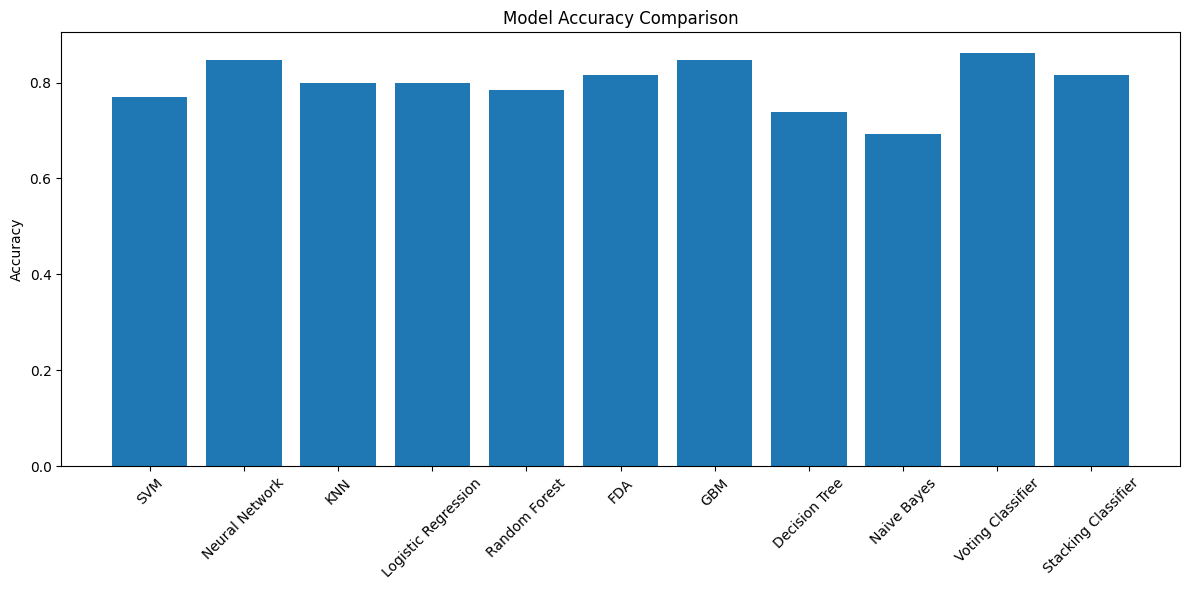

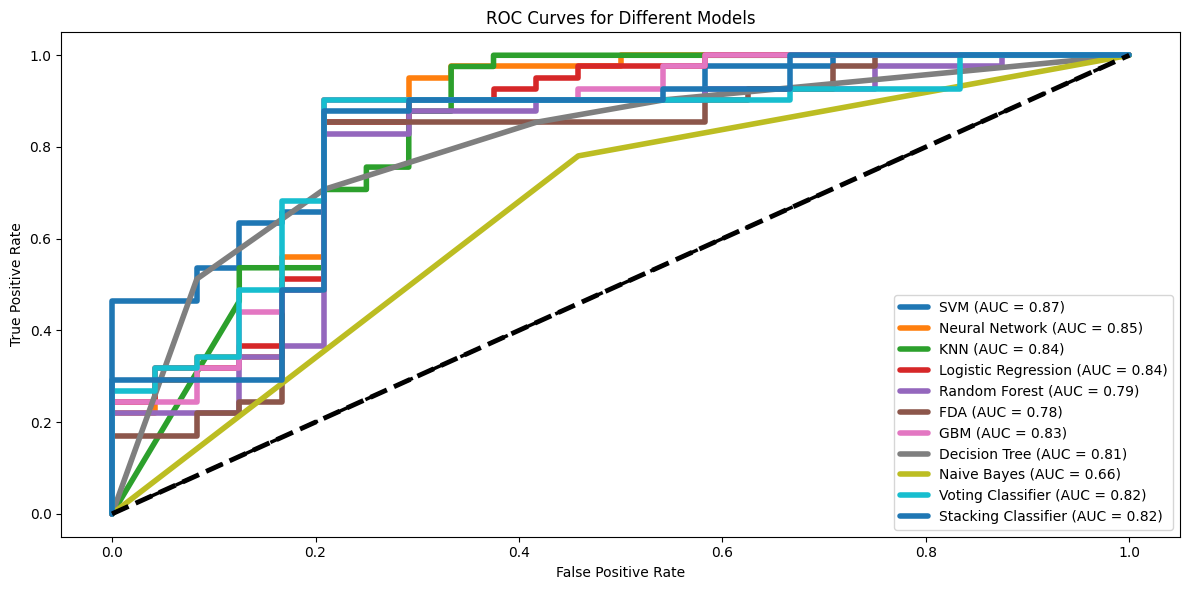

/var/folders/yz/lp8h6q9s1mq3w3hrc197vzhc0000gn/T/ipykernel_18884/2135770722.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = data[selected_columns].applymap(lambda seq: sequence_to_features(seq, seq_type='aa')).values.tolist()


Data of label:  Amino_Acid

Data Split Summary:
Total sequences: 162
Training sequences: 97
Test sequences: 65

Training set label distribution:
1    60
0    37
Name: count, dtype: int64

Test set label distribution:
1    41
0    24
Name: count, dtype: int64


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-pac

Optimizing SVM...
Best parameters for SVM: {'C': 10, 'class_weight': None, 'gamma': 'auto', 'kernel': 'poly'}
Best cross-validation score: 0.8358

Optimizing Neural Network...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-pac

Best parameters for Neural Network: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 2000}
Best cross-validation score: 0.8053

Optimizing KNN...
Best parameters for KNN: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.8663

Optimizing Logistic Regression...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-pac

Best parameters for Logistic Regression: {'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score: 0.8353

Optimizing Random Forest...
Best parameters for Random Forest: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score: 0.8563

Optimizing FDA...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:591: RuntimeWarning: divide by zero encountered in matmul
  self.xbar_ = self.priors_ @ self.means_
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:591: RuntimeWarning: overflow encountered in matmul
  self.xbar_ = self.priors_ @ self.means_
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:591: RuntimeWarning: invalid value encountered in matmul
  self.xbar_ = self.priors_ @ self.means_
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:613: RuntimeWarning: divide by zero encountered in matmul
  X = (
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:613: RuntimeWarning: overflow e

Cross-validation scores for FDA: 0.6489 (+/- 0.2583)

Optimizing GBM...
Best parameters for GBM: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.8563

Optimizing Decision Tree...
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best cross-validation score: 0.7932

Optimizing Naive Bayes...
Cross-validation scores for Naive Bayes: 0.7437 (+/- 0.1769)

Optimizing Voting Classifier...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib

Cross-validation scores for Voting Classifier: 0.8458 (+/- 0.1713)

Optimizing Stacking Classifier...


/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mavericktrinh/Personal/Predictive-Model-Advance/.venv/lib/python3.9/site-pac

Cross-validation scores for Stacking Classifier: 0.8353 (+/- 0.1503)


Results for SVM:
Accuracy: 0.8000
Precision: 0.8043
Recall: 0.9024
F1 Score: 0.8506
AUC Score: 0.8262

Results for Neural Network:
Accuracy: 0.7692
Precision: 0.7600
Recall: 0.9268
F1 Score: 0.8352
AUC Score: 0.8130

Results for KNN:
Accuracy: 0.8154
Precision: 0.8222
Recall: 0.9024
F1 Score: 0.8605
AUC Score: 0.8283

Results for Logistic Regression:
Accuracy: 0.8154
Precision: 0.8372
Recall: 0.8780
F1 Score: 0.8571
AUC Score: 0.7520

Results for Random Forest:
Accuracy: 0.8154
Precision: 0.8372
Recall: 0.8780
F1 Score: 0.8571
AUC Score: 0.8028

Results for FDA:
Accuracy: 0.7692
Precision: 0.7955
Recall: 0.8537
F1 Score: 0.8235
AUC Score: 0.6982

Results for GBM:
Accuracy: 0.8308
Precision: 0.8750
Recall: 0.8537
F1 Score: 0.8642
AUC Score: 0.8567

Results for Decision Tree:
Accuracy: 0.7231
Precision: 0.7805
Recall: 0.7805
F1 Score: 0.7805
AUC Score: 0.7027

Results for Naive Bayes:
Accuracy: 0.7231
Precision: 0.755

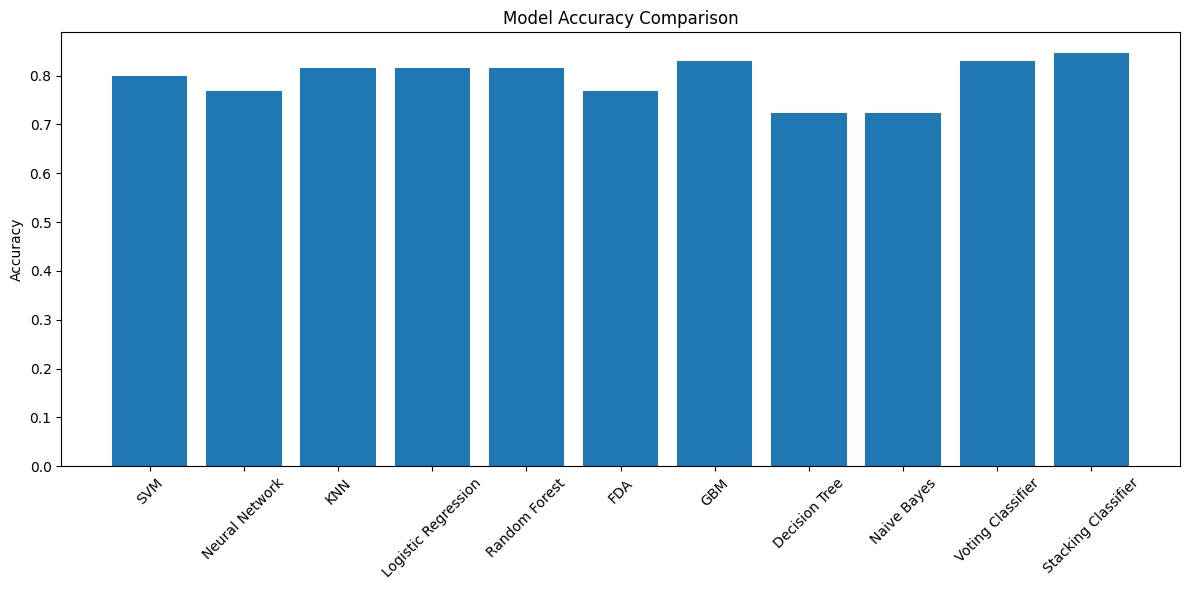

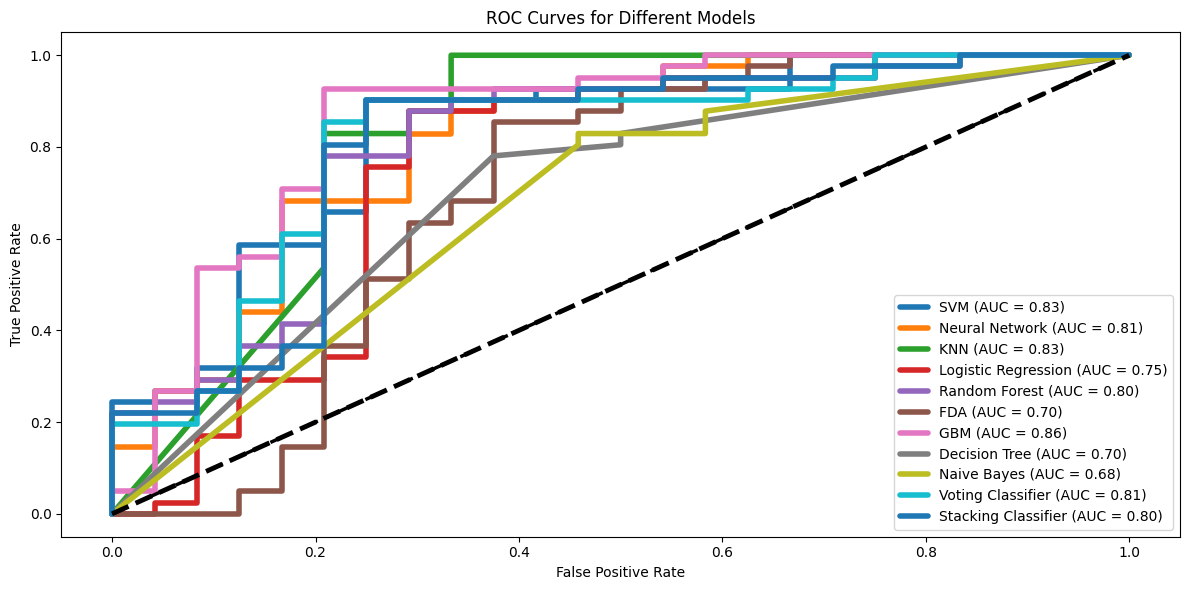

In [24]:
data_path = "data/data_training_162_model.csv"

# 1) Prepare Nucleotide-based dataset
X_nu, y_nu, original_data = prepare_data_nucleotide(data_path)
results_nu = train_and_evaluate_models(X_nu, y_nu, label='Nucleotide',
                         save_path='outputs/Experiment_Nu', original_data=original_data)

# 2) Prepare Amino_Acid-based dataset
X_aa, y_aa, original_data = prepare_data_amino(data_path)
results_aa = train_and_evaluate_models(X_aa, y_aa, label='Amino_Acid',
                         save_path='outputs/Experiment_Amin', original_data=original_data)